In [1]:
import numpy as np
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.stats import sigma_clipped_stats
from extinction import apply, remove
from extinction import fitzpatrick99 as f99
from extinction import calzetti00 as c00
from scipy.interpolate import interp1d
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pyneb as pn
import emcee
import re

# function to upload fits
def upload_data(name_fits, name_fits_error):
    with fits.open(name_fits) as hdu:
        data = hdu[0].data
        data[np.isnan(data)] = 0
    with fits.open(name_fits_error) as hdu:
        data_error = hdu[0].data
        data_error[np.isnan(data_error)] = 0
    return data, data_error

# function to upload reg files with coordinates
def upload_coords(name_reg):
    with open(name_reg, "r") as f:
        lines = f.readlines()
    coordinates = []
    for line in lines:
        match = re.search(r'circle\(([\d.]+),([\d.]+),([\d.]+)\)', line)
        if match:
            x, y, r = map(float, match.groups())
            if r > 0:
                coordinates.append((x, y, r))
    return coordinates

# fuction to calculate fluxes from data using photutils
def calculate_flux(data, data_error, coordinates):
    fluxes = []
    fluxes_errors = []
    for x, y, r in coordinates:
        aperture = CircularAperture((x, y), r=r)
        annulus = CircularAnnulus((x, y), r_in=r+1.5, r_out=r+2.5)
        phot_table = aperture_photometry(data, [aperture, annulus])
        flux_total = phot_table["aperture_sum_0"][0]
        
        phot_table_err = aperture_photometry(data_error**2, [aperture, annulus])
        flux_error_total = np.sqrt(phot_table_err["aperture_sum_0"][0])
    
        annulus_mask = annulus.to_mask(method="center")
        annulus_data = annulus_mask.multiply(data)  
        annulus_data = annulus_data[annulus_mask.data > 0]  
        
        annulus_data_error = annulus_mask.multiply(data_error)  
        annulus_data_error = annulus_data_error[annulus_mask.data > 0]  

        _, median_bkg, _ = sigma_clipped_stats(annulus_data)  # background median
        _, _, std_bkg_error = sigma_clipped_stats(annulus_data_error) # background error std
        
        area_ap = aperture.area
        
        flux_bkg = median_bkg*area_ap # background flux
        flux_bkg_error = std_bkg_error*area_ap  # background error

        # net flux and net flux errro
        flux_net = flux_total - flux_bkg
        flux_net_error = np.sqrt(flux_error_total**2 + flux_bkg_error**2)

        fluxes.append(flux_net)
        fluxes_errors.append(flux_net_error)
        
    return np.array(fluxes), np.array(fluxes_errors)


In [2]:
reg_file = "reg/NGC0628_coords_edit.reg"

file_Ha = "slices/NGC0628_MAPS_copt_0.92asec_Ha.fits"                     # Ha (6562)
file_error_Ha = "slices/NGC0628_MAPS_copt_0.92asec_Ha_error.fits"         

file_Hb = "slices/NGC0628_MAPS_copt_0.92asec_Hb.fits"                     # Hb (4861)
file_error_Hb = "slices/NGC0628_MAPS_copt_0.92asec_Hb_error.fits"

file_OIII = "slices/NGC0628_MAPS_copt_0.92asec_OIII5006.fits"               # OIII (5006)
file_error_OIII = "slices/NGC0628_MAPS_copt_0.92asec_OIII5006_error.fits"

file_NIIa = "slices/NGC0628_MAPS_copt_0.92asec_NII6583.fits"               # NII (6583)
file_error_NIIa = "slices/NGC0628_MAPS_copt_0.92asec_NII6583_error.fits"

file_NIIb = "slices/NGC0628_MAPS_copt_0.92asec_NII6548.fits"               # NII (6548)
file_error_NIIb = "slices/NGC0628_MAPS_copt_0.92asec_NII6548_error.fits"

file_SIIa = "slices/NGC0628_MAPS_copt_0.92asec_SII6716.fits"                   # SII (6716)
file_error_SIIa = "slices/NGC0628_MAPS_copt_0.92asec_SII6716_error.fits"

file_SIIb = "slices/NGC0628_MAPS_copt_0.92asec_SII6730.fits"                   # SII (6730)
file_error_SIIb = "slices/NGC0628_MAPS_copt_0.92asec_SII6730_error.fits"

coords = upload_coords(reg_file)

data_Ha, data_error_Ha = upload_data(file_Ha, file_error_Ha)
Ha, e_Ha = calculate_flux(data_Ha, data_error_Ha, coords)

data_Hb, data_error_Hb = upload_data(file_Hb, file_error_Hb)
Hb, e_Hb = calculate_flux(data_Hb, data_error_Hb, coords)

data_OIII, data_error_OIII = upload_data(file_OIII, file_error_OIII)
OIII, e_OIII = calculate_flux(data_OIII, data_error_OIII, coords)

data_NIIa, data_error_NIIa = upload_data(file_NIIa, file_error_NIIa)
NIIa, e_NIIa = calculate_flux(data_NIIa, data_error_NIIa, coords)

data_NIIb, data_error_NIIb = upload_data(file_NIIb, file_error_NIIb)
NIIb, e_NIIb = calculate_flux(data_NIIb, data_error_NIIb, coords)

data_SIIa, data_error_SIIa = upload_data(file_SIIa, file_error_SIIa)
SIIa, e_SIIa = calculate_flux(data_SIIa, data_error_SIIa, coords)

data_SIIb, data_error_SIIb = upload_data(file_SIIb, file_error_SIIb)
SIIb, e_SIIb = calculate_flux(data_SIIb, data_error_SIIb, coords)


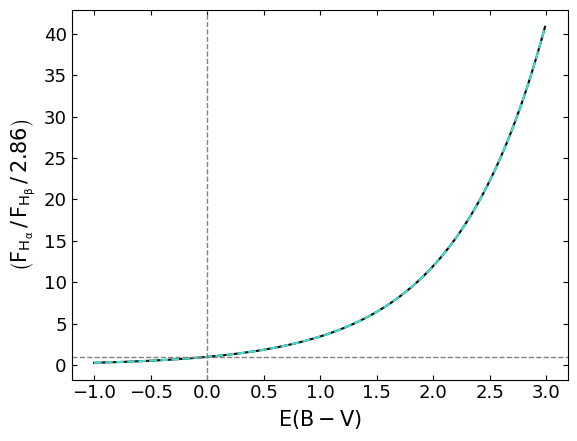

The Balmer decrement correction starts


In [3]:
x_ds, y_ds, aper = zip(*coords) 
x_ds = list(x_ds)
y_ds = list(y_ds)
aper = list(aper)

sn_Ha = []
sn_Hb = []
sn_NIIa = []
sn_NIIb = []
sn_SIIa = []
sn_SIIb = []
sn_OIII = []
for i in range(len(Ha)):
    sn_Ha.append(Ha[i]/e_Ha[i])
    sn_NIIa.append(NIIa[i]/e_NIIa[i])
    sn_NIIb.append(NIIb[i]/e_NIIb[i])
    sn_Hb.append(Hb[i]/e_Hb[i])
    sn_SIIa.append(SIIa[i]/e_SIIa[i])
    sn_SIIb.append(SIIb[i]/e_SIIb[i])
    sn_OIII.append(OIII[i]/e_OIII[i])


e_corr_Ha=[]
e_corr_Hb=[]
e_corr_OIII=[]
e_corr_NIIa=[]
e_corr_NIIb=[]
e_corr_SIIa=[]
e_corr_SIIb=[]

flux_corr_Ha=[]
flux_corr_Hb=[]
flux_corr_NIIa=[]
flux_corr_NIIb=[]
flux_corr_OIII=[]
flux_corr_SIIa=[]
flux_corr_SIIb=[]

x_ds_un = []
y_ds_un = []
Ha_un = []
Hb_un = []
NIIa_un = []
NIIb_un = []
SIIa_un = []
SIIb_un = []
OIII_un = []
aper_un = []

flux_corr_Ha_f1 = []
flux_corr_Hb_f1 = []
flux_corr_NIIa_f1 = []
flux_corr_NIIb_f1 = []
flux_corr_SIIa_f1 = []
flux_corr_SIIb_f1 = []
flux_corr_OIII_f1 = []

flux_corr_Ha_f2 = []
flux_corr_Hb_f2 = []
flux_corr_NIIa_f2 = []
flux_corr_NIIb_f2 = []
flux_corr_SIIa_f2 = []
flux_corr_SIIb_f2 = []
flux_corr_OIII_f2 = []

e_corr_Ha = []
e_corr_Hb = []
e_corr_NIIa = []
e_corr_NIIb = []
e_corr_SIIa = []
e_corr_SIIb = []
e_corr_OIII = []
e_f_corr_Ha = []
e_f_corr_Hb = []
e_f_corr_NIIa = []
e_f_corr_NIIb = []
e_f_corr_SIIa = []
e_f_corr_SIIb = []
e_f_corr_OIII = []
e_HaHb = []
EBV = []

w_min=4861
w_max=6731
def ebv_interpol(w_min, w_max):

    wave = np.array([w_min,w_max])   
    flux = [1.,2.86]
    ebv = np.array(list(range(-100,300)))*0.01
    rat = ebv*0.00000000
        
    # For each value of EBV (between -1 and 2.99), the extinction 
    # is removed from the flux values 1 and 2.86 for Hb and Ha, respectively,
    # and the ratio between them is calculated
    
    for i in list(range(400)):
        fcor = remove(f99(wave,-3.1*ebv[i], 3.1), flux)
        rat[i] = fcor[1]/fcor[0]
        
        
    # Se crea la funcion de interpolacion entre esos valores de ebv y ratio
    inter_ratebv = interp1d(rat, ebv)
       
    # Plot de rat vs ebv y rat vs la interpolacion
       
    fig, ax = plt.subplots()
    plt.plot(ebv, rat/2.86, color = 'k', lw = 1.5);
    plt.plot(inter_ratebv(rat), rat/2.86, color = 'turquoise', lw = 1.5, ls='dashed');
    plt.xlabel(r'$\rm{E(B-V)}$', fontsize=15);
    plt.ylabel(r'$\rm{\left(F_{H_{\alpha}} \, / \, F_{H_{\beta}} \, / \, 2.86 \right)}$', fontsize=15);
    plt.xticks(fontsize=13);
    plt.yticks(fontsize=13);
    ax.get_yaxis().set_tick_params(right = True, which='both', direction='in')
    ax.get_xaxis().set_tick_params(top = True, which='both', direction='in')
    plt.axvline(0., color = 'grey', ls = '--', lw = 1.0);
    plt.axhline(1.0, color = 'grey', ls = '--', lw = 1.0);
    plt.savefig('EBV_interpol.pdf')
    #plt.close()
    plt.show()

    return inter_ratebv


#-----------------------------------------------------------

#def corr_maps(w_min,w_max):
    
N=3 #Three possible values for  activity (three colors)
inter_ratebv=ebv_interpol(w_min,w_max)
#lines, e_lines, sn_lines=read_lines(f_lines)  
    

wave_Hb=np.array([4861]) 
wave_OIII=np.array([5007])
wave_Ha=np.array([6563])
wave_NIIa=np.array([6583])
wave_NIIb=np.array([6548])
wave_SIIa=np.array([6716])
wave_SIIb=np.array([6731])
    
    
    
#Read the lines and errors from the dictionary
    
#We propagate the errors of the interpolation


    
    
# We generate an array for the EBV values
    
#EBV = np.empty((len(Ha))); EBV[:] = np.nan   

print ('The Balmer decrement correction starts')

for i in range (len(Ha)):
    if sn_Ha[i]>3.0 and sn_Hb[i]>3.0 and Ha[i]!=0 and Hb[i]!=0: # guarda las fuentes para las que el S/N en Ha y Hb es > 3
        ratio_med = np.float64(Ha[i])/np.float64(Hb[i])
       
  
        if ratio_med < 2.86:
            ratio_med = 2.86
        EBV.append(inter_ratebv(ratio_med)) # it creates the EBV list. For each source theratio_med which is the Ha/Hb should be >= 2.86
       
        e_HaHb.append(np.sqrt((e_Hb[i]/Ha[i])**2.0+(Hb[i]*e_Ha[i]/(Ha[i])**2.0)**2.0))
        
        x_ds_un.append(x_ds[i]) # here x_ds and y_ds are the coordinates of each source
        y_ds_un.append(y_ds[i])
        Ha_un.append(Ha[i])
        Hb_un.append(Hb[i])
        NIIa_un.append(NIIa[i])
        NIIb_un.append(NIIb[i])
        SIIa_un.append(SIIa[i])
        SIIb_un.append(SIIb[i])
        OIII_un.append(OIII[i])
        aper_un.append(aper[i])

# starts correction extinction
for i in range (len(Ha_un)):
		#These are the extinction corrected fluxes 
        flux_corr_Ha.append(apply(f99(wave_Ha,-3.1*EBV[i],3.1),np.float64(Ha_un[i])))
        flux_corr_Hb.append(apply(f99(wave_Hb,-3.1*EBV[i],3.1),np.float64(Hb_un[i])))
        flux_corr_NIIa.append(apply(f99(wave_NIIa,-3.1*EBV[i],3.1),np.float64(NIIa_un[i])))
        flux_corr_NIIb.append(apply(f99(wave_NIIb,-3.1*EBV[i],3.1),np.float64(NIIb_un[i])))
        flux_corr_OIII.append(apply(f99(wave_OIII,-3.1*EBV[i],3.1),np.float64(OIII_un[i])))
        flux_corr_SIIa.append(apply(f99(wave_SIIa,-3.1*EBV[i],3.1),np.float64(SIIa_un[i])))
        flux_corr_SIIb.append(apply(f99(wave_SIIb,-3.1*EBV[i],3.1),np.float64(SIIb_un[i])))


#Propagation of the errors of the interpolation 
for i in range (len(Ha_un)):   
        #print(flux_corr_Ha[i])
        flux_corr_Ha_f1.append(apply(f99(wave_Ha,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_Ha[i][0])))
        flux_corr_Hb_f1.append(apply(f99(wave_Hb,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_Hb[i][0])))
        flux_corr_NIIa_f1.append(apply(f99(wave_NIIa,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_NIIa[i][0])))
        flux_corr_NIIb_f1.append(apply(f99(wave_NIIb,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_NIIb[i][0])))
        flux_corr_OIII_f1.append(apply(f99(wave_OIII,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_OIII[i][0])))
        flux_corr_SIIa_f1.append(apply(f99(wave_SIIa,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_SIIa[i][0])))
        flux_corr_SIIb_f1.append(apply(f99(wave_SIIb,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_SIIb[i][0])))

           
        flux_corr_Ha_f2.append(apply(f99(wave_Ha,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_Ha[i][0])))
        flux_corr_Hb_f2.append(apply(f99(wave_Hb,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_Hb[i][0])))
        flux_corr_NIIa_f2.append(apply(f99(wave_NIIa,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_NIIa[i][0])))
        flux_corr_NIIb_f2.append(apply(f99(wave_NIIb,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_NIIb[i][0])))
        flux_corr_OIII_f2.append(apply(f99(wave_OIII,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_OIII[i][0])))
        flux_corr_SIIa_f2.append(apply(f99(wave_SIIa,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_SIIa[i][0])))
        flux_corr_SIIb_f2.append(apply(f99(wave_SIIb,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_SIIb[i][0])))

        
        e_f_corr_Ha.append(0.5*abs(flux_corr_Ha_f2[i]-flux_corr_Ha_f1[i]))
        e_f_corr_Hb.append(0.5*abs(flux_corr_Hb_f2[i]-flux_corr_Hb_f1[i]))
        e_f_corr_NIIa.append(0.5*abs(flux_corr_NIIa_f2[i]-flux_corr_NIIa_f1[i]))
        e_f_corr_NIIb.append(0.5*abs(flux_corr_NIIb_f2[i]-flux_corr_NIIb_f1[i]))
        e_f_corr_OIII.append(0.5*abs(flux_corr_OIII_f2[i]-flux_corr_OIII_f1[i]))
        e_f_corr_SIIa.append(0.5*abs(flux_corr_SIIa_f2[i]-flux_corr_SIIa_f1[i]))
        e_f_corr_SIIb.append(0.5*abs(flux_corr_SIIb_f2[i]-flux_corr_SIIb_f1[i]))

        # Final errors. The ones we keep
        e_corr_Ha.append(np.sqrt(e_Ha[i]**2+e_f_corr_Ha[i]**2))
        e_corr_Hb.append(np.sqrt(e_Hb[i]**2+e_f_corr_Hb[i]**2))
        e_corr_OIII.append(np.sqrt(e_OIII[i]**2+e_f_corr_OIII[i]**2))
        e_corr_NIIa.append(np.sqrt(e_NIIa[i]**2+e_f_corr_NIIa[i]**2))
        e_corr_NIIb.append(np.sqrt(e_NIIb[i]**2+e_f_corr_NIIb[i]**2))
        e_corr_SIIa.append(np.sqrt(e_SIIa[i]**2+e_f_corr_SIIa[i]**2))
        e_corr_SIIb.append(np.sqrt(e_SIIb[i]**2+e_f_corr_SIIb[i]**2))

In [4]:
aper = np.array(aper)

flux_corr_SIIa = np.array(SIIa)
flux_corr_SIIb = np.array(SIIb)
flux_corr_NIIa = np.array(NIIa)
flux_corr_NIIb = np.array(NIIb)
flux_corr_OIII = np.array(OIII)
flux_corr_Ha = np.array(Ha)
flux_corr_Hb = np.array(Hb)

e_corr_SIIa = np.array(e_SIIa)
e_corr_SIIb = np.array(e_SIIb)
e_corr_NIIa = np.array(e_NIIa)
e_corr_NIIb = np.array(e_NIIb)
e_corr_OIII = np.array(e_OIII)
e_corr_Ha = np.array(e_Ha)
e_corr_Hb = np.array(e_Hb)

# calculate the SII(6716+6730)
flux_corr_SII = flux_corr_SIIa + flux_corr_SIIb
e_corr_SII = np.sqrt(e_corr_SIIa**2 + e_corr_SIIb**2)

# calculate the SII(6583+6548)
flux_corr_NII = flux_corr_NIIa + flux_corr_NIIb
e_corr_NII = np.sqrt(e_corr_NIIa**2 + e_corr_NIIb**2)

size = len(flux_corr_Ha)

x_snr = np.full(size, np.nan)
y_snr = np.full(size, np.nan)
Ha_snr = np.full(size, np.nan)
e_Ha_snr = np.full(size, np.nan)
Hb_snr = np.full(size, np.nan)
e_Hb_snr = np.full(size, np.nan)
SII_snr = np.full(size, np.nan)
e_SII_snr = np.full(size, np.nan)
NIIa_snr = np.full(size, np.nan)
e_NIIa_snr = np.full(size, np.nan)
OIII_snr = np.full(size, np.nan)
e_OIII_snr = np.full(size, np.nan)
diag_snr = np.full((size, 5), '', dtype=object)

In [5]:
# SII-NII diagnostic
a30 = -0.043
a21 = 0.175
a20 = -0.257
a12 = 0.029
a11 = -2.452
a10 = 2.244
a03 = -0.217
a02 = 1.388
a01 = 1.116
a00 = 2.763
f_SII_NII = lambda x, y: (a30*x**3.0 + a21*x**2.0*y + a20*x**2.0 + a12*x*y**2.0 + a11*x*y + a10*x + a03*y**3.0 + a02*y**2.0 + a01*y + a00)

for i in range(len(flux_corr_Ha)):
    # we apply 3 flux condicions
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_SII[i]/e_corr_SII[i]
    cond3 = flux_corr_NIIa[i]/e_corr_NIIa[i]
    if cond1>3.0 and cond2>3.0 and cond3>3.0 and flux_corr_Ha[i]!=0 and flux_corr_SII[i]!=0 and flux_corr_NIIa[i]!=0:
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i]/flux_corr_SII[i])**2 + (e_corr_Ha[i]/flux_corr_Ha[i])**2)
        ratio_NII_Ha = flux_corr_NIIa[i] / flux_corr_Ha[i]
        ratio_NII_Ha_error = ratio_NII_Ha * np.sqrt((e_corr_NIIa[i] / flux_corr_NIIa[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)
        # we apply 2 flux condicions
        cond4 = ratio_SII_Ha / ratio_SII_Ha_error
        cond5 = ratio_NII_Ha / ratio_NII_Ha_error
        if cond4>3.0 and cond5>3.0 and ratio_SII_Ha!=0 and ratio_NII_Ha!=0:
            if f_SII_NII(np.log10(ratio_SII_Ha),np.log10(ratio_NII_Ha))>0: # save everything from this source
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][0]='SII-NII' # also save the diagnostic that passed positive
        

In [6]:
# NII-OIII diagnostic
a10 = 0.939
a01 = 1.000
a00 = 0.469                         
f_NII_OIII = lambda x, y: (a10*x + a01*y + a00)


for i in range(len(flux_corr_Ha)):
    cond0 = flux_corr_Hb[i]/e_corr_Hb[i]
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_OIII[i]/e_corr_OIII[i]
    cond3 = flux_corr_NIIa[i]/e_corr_NIIa[i]
    if cond0>3.0 and cond1>3.0 and cond2>3.0 and cond3>3.0 and flux_corr_Ha[i]!=0 and flux_corr_Hb[i]!=0 and flux_corr_OIII[i]!=0 and flux_corr_NIIa[i]!=0:
        ratio_OIII_Hb = flux_corr_OIII[i] / flux_corr_Hb[i]
        ratio_OIII_Hb_error = ratio_OIII_Hb * np.sqrt((e_corr_OIII[i]/flux_corr_OIII[i])**2 + (e_corr_Hb[i]/flux_corr_Hb[i])**2)
        ratio_NII_Ha = flux_corr_NIIa[i] / flux_corr_Ha[i]
        ratio_NII_Ha_error = ratio_NII_Ha * np.sqrt((e_corr_NIIa[i] / flux_corr_NIIa[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)
        cond4 = ratio_OIII_Hb / ratio_OIII_Hb_error
        cond5 = ratio_NII_Ha / ratio_NII_Ha_error
        if cond4>3.0 and cond5>3.0 and ratio_OIII_Hb!=0 and ratio_NII_Ha!=0:
            if f_NII_OIII(np.log10(ratio_NII_Ha),np.log10(ratio_OIII_Hb))>0:
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][1]='NII-OIII'

In [7]:
# SII-OIII diagnostic
a30 = 0.079
a21 = 0.148
a20 = -1.821
a12 = -0.318
a11 = -0.781
a10 = 4.66
a03 = 0.255
a02 = -0.479
a01 = 4.433
a00 = 3.403
f_SII_OIII = lambda x, y: (a30*x**3.0 + a21*x**2.0*y + a20*x**2.0 + a12*x*y**2.0 + a11*x*y + 
                           a10*x + a03*y**3.0 + a02*y**2.0 + a01*y + a00)


for i in range(len(flux_corr_Ha)):
    cond0 = flux_corr_Hb[i]/e_corr_Hb[i]
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_OIII[i]/e_corr_OIII[i]
    cond3 = flux_corr_SII[i]/e_corr_SII[i]  
    if cond0>3.0 and cond1>3.0 and cond2>3.0 and cond3>3.0 and flux_corr_Ha[i]!=0 and flux_corr_Hb[i]!=0 and flux_corr_OIII[i]!=0 and flux_corr_SII[i]!=0:  
        ratio_OIII_Hb = flux_corr_OIII[i] / flux_corr_Hb[i]
        ratio_OIII_Hb_error = ratio_OIII_Hb * np.sqrt((e_corr_OIII[i]/flux_corr_OIII[i])**2 + (e_corr_Hb[i]/flux_corr_Hb[i])**2)
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]  
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i] / flux_corr_SII[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2) 
        cond4 = ratio_OIII_Hb / ratio_OIII_Hb_error
        cond5 = ratio_SII_Ha / ratio_SII_Ha_error  
        if cond4>3.0 and cond5>3.0 and ratio_OIII_Hb!=0 and ratio_SII_Ha!=0:  #
            if f_SII_OIII(np.log10(ratio_SII_Ha), np.log10(ratio_OIII_Hb))>0:  
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][2]='SII-OIII'


In [8]:
# NII-SII-OIII diagnostic
a300 = -2.913
a201 = -0.638
a210 = 1.568
a200 = 0.407
a102 = -0.866
a111 = -2.264
a101 = 1.508
a120 = 1.753
a110 = -6.913
a100 = 0.001
a003 = 1.463
a012 = -1.325
a002 = -2.732
a021 = 1.823
a011 = -2.697
a001 = 4.377
a030 = -1.585
a020 = 0.770
a010 = 1.267
a000 = 2.413                        
f_NII_SII_OIII = lambda x, y, z:(a300*x**3 + a201*x**2*z + a210*x**2*y + a200*x**2 + a102*x*z**2 + a111*x*y*z + 
                                 a101*x*z + a120*x*y**2 + a110*x*y + a100*x + a003*z**3 + a012*y*z**2 + 
                                 a002*z**2 + a021*y**2*z + a011*y*z + a001*z + a030*y**3 + a020*x*y**2+  
                                 a010*y + a000)


for i in range(len(flux_corr_Ha)):
    cond0 = flux_corr_Hb[i]/e_corr_Hb[i]
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_OIII[i]/e_corr_OIII[i]
    cond3 = flux_corr_SII[i]/e_corr_SII[i]  
    cond4 = flux_corr_NIIa[i]/e_corr_NIIa[i]
    if cond0>3.0 and cond1>3.0 and cond2>3.0 and cond3>3.0 and cond4>3.0 and flux_corr_Ha[i]!=0 and flux_corr_Hb[i]!=0 and flux_corr_OIII[i]!=0 and flux_corr_SII[i]!=0 and flux_corr_NII[i]!=0:  
        ratio_OIII_Hb = flux_corr_OIII[i] / flux_corr_Hb[i]
        ratio_OIII_Hb_error = ratio_OIII_Hb * np.sqrt((e_corr_OIII[i]/flux_corr_OIII[i])**2 + (e_corr_Hb[i]/flux_corr_Hb[i])**2)
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]  
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i] / flux_corr_SII[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)  
        ratio_NII_Ha = flux_corr_NIIa[i] / flux_corr_Ha[i]
        ratio_NII_Ha_error = ratio_NII_Ha * np.sqrt((e_corr_NIIa[i] / flux_corr_NIIa[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)
        cond5 = ratio_OIII_Hb / ratio_OIII_Hb_error
        cond6 = ratio_SII_Ha / ratio_SII_Ha_error  
        cond7 = ratio_NII_Ha / ratio_NII_Ha_error
        if cond5>3.0 and cond6>3.0 and cond7>3.0 and ratio_OIII_Hb!=0 and ratio_SII_Ha!=0 and ratio_NII_Ha!=0:  #
            if f_NII_SII_OIII(np.log10(ratio_NII_Ha), np.log10(ratio_SII_Ha), np.log10(ratio_OIII_Hb))>0:  
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][3]='NII-SII-OIII'

In [9]:
# SII-Ha diagnostic antic

for i in range(len(flux_corr_Ha)):
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_SII[i]/e_corr_SII[i]
    if cond1>3.0 and cond2>3.0 and flux_corr_Ha[i]!=0 and flux_corr_SII[i]!=0:
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i]/flux_corr_SII[i])**2 + (e_corr_Ha[i]/flux_corr_Ha[i])**2)
        cond4 = ratio_SII_Ha / ratio_SII_Ha_error
        if cond4>3.0 and ratio_SII_Ha!=0:
            if ratio_SII_Ha>0.4:
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][4]='SII-Ha'
        

In [10]:
output_file = "reg/NGC0628_coords_code.reg"  # .reg with all coordinates with sources that passed the diagnostics
output_file_1 = "reg/NGC0628_coords_code_1.reg" # .reg with all coordinates with sources only 1 diagnostic
output_file_2 = "reg/NGC0628_coords_code_2.reg" # .reg with all coordinates with sources that passed only 2 diagnostics
output_file_3 = "reg/NGC0628_coords_code_3.reg" # .reg with all coordinates with sources that passed only 2 diagnostics
output_file_4 = "reg/NGC0628_coords_code_4.reg" # .reg with all coordinates with sources that passed only 2 diagnostics
output_file_5 = "reg/NGC0628_coords_code_5.reg" # .reg with all coordinates with sources that passed only 2 diagnostics
output_file_idx = "reg/NGC0628_coords_code_idx.reg" # .reg with all coordinates with sources that passed 3 or more diagnostics

with open(output_file, "w") as f0, open(output_file_1, "w") as f1, open(output_file_2, "w") as f2, open(output_file_3, "w") as f3, open(output_file_4, "w") as f4, open(output_file_5, "w") as f5, open(output_file_idx, "w") as f6:
    
    for i in range(size):
        if not np.isnan(x_snr[i]):
            f0.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n") # all sources
            diag=0
            for j in range(5):
                if (not diag_snr[i][j])==False:
                    diag+=1
            if diag==1:    # 1 diagnostics
                f1.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==2:  # 2 diagnostics
                f2.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==3:  # 3 diagnostics
                f3.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==4:  # 4 diagnostics
                f4.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==5:  # 5 diagnostics
                f5.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            if diag>=3:    # 3 or more diagnostics
                f6.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]+2}) # text={{{i}}}\n")

In [11]:
coords_deleted = x_snr.copy()
idx_deleted = [373, 574, 1343, 98, 75, 45, 76, 1014]  # indexs deleted of sources partially outside the flux map

for i in idx_deleted:
    coords_deleted[i] = np.nan

for i in range(size):
    if not np.isnan(x_snr[i]):
        diag=0
        for j in range(5):
            if (not diag_snr[i][j])==False:
                diag+=1
        if diag==1 or diag==2: # discard the sources with less than 3 diagnostics
            coords_deleted[i] = np.nan
        if diag==3: 
            if diag_snr[i][4]=='SII-Ha': # discard the sources that have 3 diagnostics but 1 is not multiline diagnostic
                coords_deleted[i] = np.nan 
                print(i, diag_snr[i])

    
factor = 10**(-20)  # Conversion factor
mask = ~np.isnan(coords_deleted)  

x_snr_f = np.array(x_snr[mask].copy(), dtype=np.float64)
y_snr_f = np.array(y_snr[mask].copy(), dtype=np.float64)
aper_snr_f = np.array(aper[mask].copy(), dtype=np.float64)
Ha_snr_f = np.array(Ha_snr[mask].copy() * factor, dtype=np.float64)
e_Ha_snr_f = np.array(e_Ha_snr[mask].copy() * factor, dtype=np.float64)
Hb_snr_f = np.array(Hb_snr[mask].copy() * factor, dtype=np.float64)
e_Hb_snr_f = np.array(e_Hb_snr[mask].copy() * factor, dtype=np.float64)
OIII_snr_f = np.array(OIII_snr[mask].copy() * factor, dtype=np.float64)
e_OIII_snr_f = np.array(e_OIII_snr[mask].copy() * factor, dtype=np.float64)
SII_snr_f = np.array(SII_snr[mask].copy() * factor, dtype=np.float64)
e_SII_snr_f = np.array(e_SII_snr[mask].copy() * factor, dtype=np.float64)
NIIa_snr_f = np.array(NIIa_snr[mask].copy() * factor, dtype=np.float64)
e_NIIa_snr_f = np.array(e_NIIa_snr[mask].copy() * factor, dtype=np.float64)

diag_snr_f = [sublist for sublist, m in zip(diag_snr, mask) if m]

# We filter out other fluxes not used in the diagnostics
SIIa_snr_f = np.array(flux_corr_SIIa[mask].copy() * factor, dtype=np.float64)
e_SIIa_snr_f = np.array(e_corr_SIIa[mask].copy() * factor, dtype=np.float64)
SIIb_snr_f = np.array(flux_corr_SIIb[mask].copy() * factor, dtype=np.float64)
e_SIIb_snr_f = np.array(e_corr_SIIb[mask].copy() * factor, dtype=np.float64)

NII_snr_f = np.array(flux_corr_NII[mask].copy() * factor, dtype=np.float64)
e_NII_snr_f = np.array(e_corr_NII[mask].copy() * factor, dtype=np.float64)


# We calculate other necessary ratios and filter
rat_OIII_Hb_snr_f = OIII_snr_f / Ha_snr_f
e_rat_OIII_Hb_snr_f = rat_OIII_Hb_snr_f * np.sqrt((e_OIII_snr_f / OIII_snr_f)**2 + (e_Hb_snr_f / Hb_snr_f)**2)

rat_SII_Ha_snr_f = SII_snr_f / Ha_snr_f
e_rat_SII_Ha_snr_f = rat_SII_Ha_snr_f * np.sqrt((e_SII_snr_f / SII_snr_f)**2 + (e_Ha_snr_f / Ha_snr_f)**2)

rat_NII_Ha_snr_f = NII_snr_f / Ha_snr_f
e_rat_NII_Ha_snr_f = rat_NII_Ha_snr_f * np.sqrt((e_NII_snr_f / NII_snr_f)**2 + (e_Ha_snr_f / Ha_snr_f)**2)

rat_NIIa_Ha_snr_f = NIIa_snr_f / Ha_snr_f
e_rat_NIIa_Ha_snr_f = rat_NIIa_Ha_snr_f * np.sqrt((e_NIIa_snr_f / NIIa_snr_f)**2 + (e_Ha_snr_f / Ha_snr_f)**2)

rat_SIIa_SIIb_snr_f = SIIa_snr_f / SIIb_snr_f
e_rat_SIIa_SIIb_snr_f = rat_SIIa_SIIb_snr_f * np.sqrt((e_SIIa_snr_f / SIIa_snr_f)**2 + (e_SIIb_snr_f / SIIb_snr_f)**2)

8 ['SII-NII' '' 'SII-OIII' '' 'SII-Ha']
66 ['SII-NII' '' 'SII-OIII' '' 'SII-Ha']
809 ['SII-NII' '' 'SII-OIII' '' 'SII-Ha']
1020 ['SII-NII' '' 'SII-OIII' '' 'SII-Ha']


In [12]:
print('Number of sources with 3 or more diagnostics filtered: ',len(x_snr_f))
print('Number of sources with 1 or more diagnostics: ',len(x_snr))

Number of sources with 3 or more diagnostics filtered:  158
Number of sources with 1 or more diagnostics:  1429


In [13]:
# MCMC functions
def log_likelihood_normal(theta, data):
    mu, sigma = theta
    if sigma <= 0 or np.isnan(mu) or np.isnan(sigma):
        return -np.inf
    return np.sum(stats.norm.logpdf(data, mu, sigma))

def log_likelihood_skewed(theta, data):
    mu, sigma, alpha = theta
    if sigma <= 0 or np.isnan(mu) or np.isnan(sigma) or np.isnan(alpha):
        return -np.inf
    return np.sum(stats.skewnorm.logpdf(data, alpha, mu, sigma))

def log_prior_normal(theta):
    mu, sigma = theta
    if 0 < sigma < 5 and 0 < mu < 5:
        return 0.0
    return -np.inf

def log_prior_skewed(theta):
    mu, sigma, alpha = theta
    if 0 < sigma < 5 and 0 < mu < 5 and -5 < alpha < 5:
        return 0.0
    return -np.inf

def log_probability_normal(theta, data):
    lp = log_prior_normal(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_normal(theta, data)  
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

def log_probability_skewed(theta, data):
    lp = log_prior_skewed(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_skewed(theta, data)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

# MCMC parameters
n_walkers = 20
n_steps = 5000
n_dim_normal = 2  # for normal distribution (mu, sigma)
n_dim_skewed = 3  # for skewed distribution (mu, sigma, alpha)

/home/pol-m-f/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


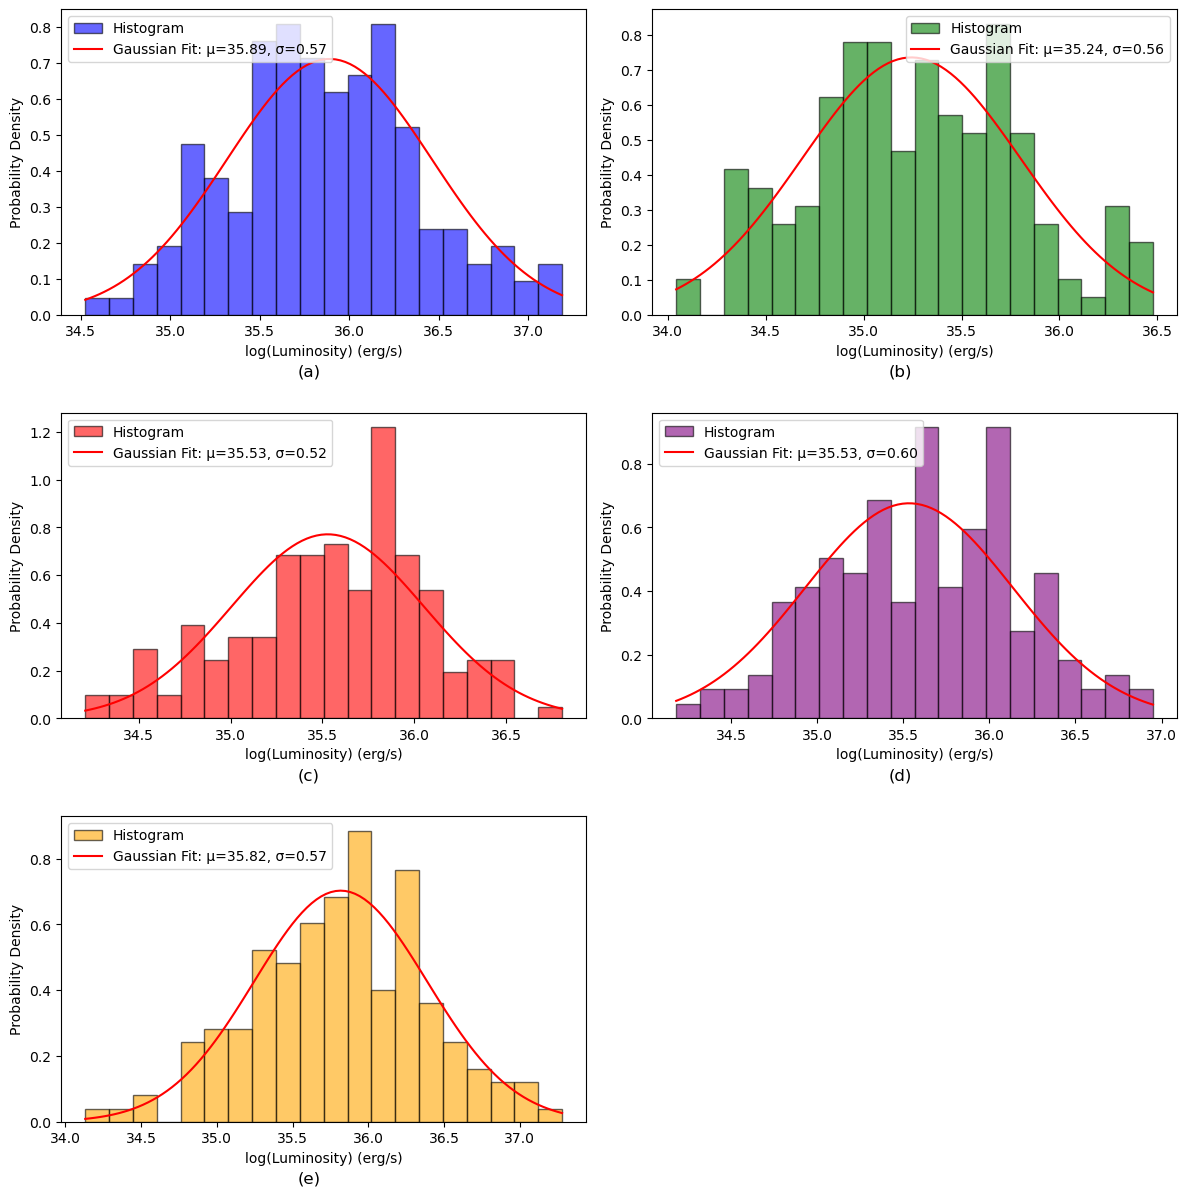

In [14]:
def luminosity(flux, distance, flux_error, distance_error):
    # Convert distance to cm (if necessary)
    distance = distance * 3.086 * 10**24
    
    # calculate luminosity
    L = 4 * np.pi * distance**2 * flux
    
    # error propagation
    L_error = np.sqrt((4 * np.pi * distance**2 * flux_error)**2 + (8 * np.pi * distance * flux * distance_error)**2)
    
    return L, L_error

dist =  8.63 # in Mpc
e_dist = 0.30

lumi_Ha, e_lumi_Ha = luminosity(Ha_snr_f, dist, e_Ha_snr_f, e_dist)
lumi_Hb, e_lumi_Hb = luminosity(Hb_snr_f, dist, e_Hb_snr_f, e_dist)
lumi_OIII, e_lumi_OIII = luminosity(OIII_snr_f, dist, e_OIII_snr_f, e_dist)
lumi_SII, e_lumi_SII = luminosity(SII_snr_f, dist, e_SII_snr_f, e_dist)
lumi_NII, e_lumi_NII = luminosity(NII_snr_f, dist, e_NII_snr_f, e_dist)


# Plot:
plt.figure(figsize=(12, 12))

luminosities = [lumi_Ha, lumi_Hb, lumi_OIII, lumi_SII, lumi_NII]
# titles = ['Ha Luminosity', 'Hb Luminosity', '[OIII] Luminosity', '[SII] Luminosity', '[NII] Luminosity']
colors = ['blue', 'green', 'red', 'purple', 'orange']
letters= ['(a)', '(b)', '(c)', '(d)','(e)']

for idx, (lumi, letter, color) in enumerate(zip(luminosities, letters, colors), start=1):
    plt.subplot(3, 2, idx)
    
    log_lumi = np.log10(lumi)
    
    plt.hist(log_lumi, bins=20, color=color, edgecolor='black', density=True, alpha=0.6, label="Histogram")
    
    # gaussian fit using MCMC
    mu_init = np.mean(log_lumi)
    sigma_init = max(np.std(log_lumi), 0.1)
    initial_positions = [np.array([mu_init, sigma_init]) + 0.1 * np.random.randn(n_dim_normal) for _ in range(n_walkers)]

    sampler = emcee.EnsembleSampler(n_walkers, n_dim_normal, log_probability_normal, args=(log_lumi,))
    sampler.run_mcmc(initial_positions, n_steps, progress=False)

    samples = sampler.get_chain(flat=True, discard=1000)
    mu_mcmc, sigma_mcmc = np.median(samples, axis=0)

    x = np.linspace(min(log_lumi), max(log_lumi), 100)
    y = stats.norm.pdf(x, mu_mcmc, sigma_mcmc)

    # normalize gaussian
    area = np.trapz(y, x)
    y_scaled = y / area

    plt.plot(x, y_scaled, 'r-', label=f'Gaussian Fit: μ={mu_mcmc:.2f}, σ={sigma_mcmc:.2f}')
    # plt.title(title)
    plt.xlabel('log(Luminosity) (erg/s)')
    plt.ylabel('Probability Density')
    plt.text(0.45, -0.2, letter, transform=plt.gca().transAxes, fontsize=12)
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.32)
plt.savefig('luminosity_NGC0628.png')
plt.show()


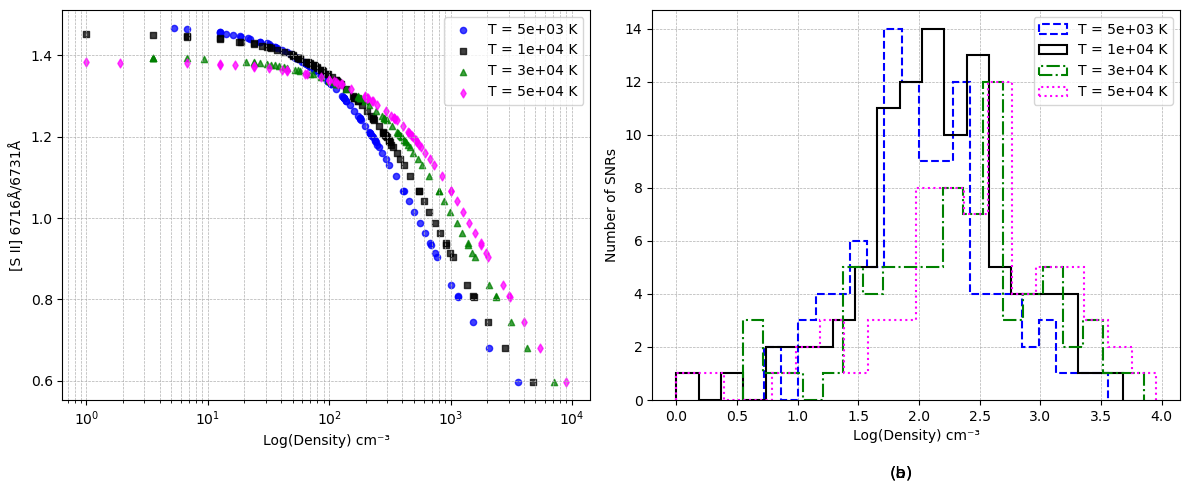

In [15]:
S2 = pn.Atom('S', 2)

temperatures = [5e3, 1e4, 3e4, 5e4]
colors = ['blue', 'black', 'green', 'magenta']
markers = ['o', 's', '^', 'd']
linestyles = ['dashed', 'solid', 'dashdot', 'dotted']

# We remove the NaNs since the function getTemDem() only returns a value within a specific range of the SII ratio and depending on the temperature
densities_dict = {}
rat_SIIa_SIIb_snr_dict = {}

for T in temperatures:
    densities = S2.getTemDen(rat_SIIa_SIIb_snr_f, tem=T, wave1=6716, wave2=6731)
    mask = ~np.isnan(densities)
    densities_dict[T] = densities[mask]
    rat_SIIa_SIIb_snr_dict[T] = rat_SIIa_SIIb_snr_f[mask]



fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

# Plot 1: [S II] Ratio vs Density
for T, color, marker in zip(temperatures, colors, markers):
    axes[0].scatter(densities_dict[T], rat_SIIa_SIIb_snr_dict[T],
                    color=color, marker=marker, label=f'T = {T:.0e} K',
                    alpha=0.75, s=20)

axes[0].set_xscale('log')
axes[0].set_xlabel('Log(Density) cm⁻³')
axes[0].set_ylabel('[S II] 6716Å/6731Å')
plt.text(0.45, -0.2, '(a)', transform=plt.gca().transAxes, fontsize=12)
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot 2: Density Distribution
for T, color, linestyle in zip(temperatures, colors, linestyles):
    axes[1].hist(np.log10(densities_dict[T]), bins=20, color=color,
                 histtype='step', linestyle=linestyle, linewidth=1.5,
                 label=f'T = {T:.0e} K')

axes[1].set_xlabel('Log(Density) cm⁻³')
axes[1].set_ylabel('Number of SNRs')
plt.text(0.45, -0.2, '(b)', transform=plt.gca().transAxes, fontsize=12)
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.savefig('density_plots_NGC0628.png')
plt.show()


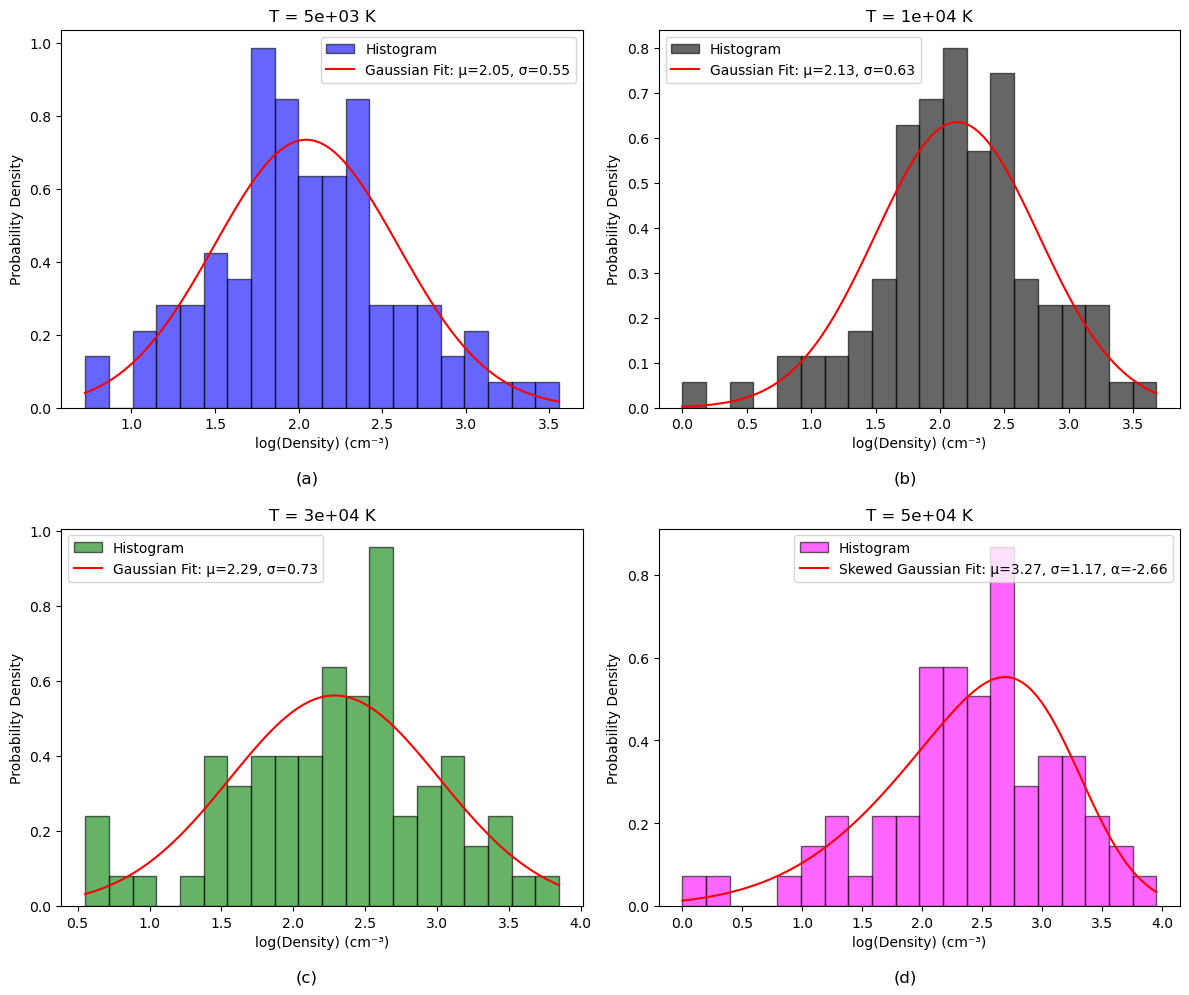

In [17]:
plt.figure(figsize=(12, 10))

colors = ['blue', 'black', 'green', 'magenta']
letters = ['(a)', '(b)', '(c)', '(d)']

for i, T in enumerate(temperatures, 1):
    # normal distribution for the first 3 subplots
    if i <= 3:
        plt.subplot(2, 2, i)
        densities = np.log10(densities_dict[T]) 
        
        if np.any(np.isnan(densities)) or np.any(np.isinf(densities)):
            raise ValueError(f"Data for T = {T} K contains NaN or Inf values!")

        plt.hist(densities, bins=20, density=True, alpha=0.6, color=colors[i-1], edgecolor='black', label="Histogram")
        
        # MCMC initialization
        mu_init = np.mean(densities)
        sigma_init = max(np.std(densities), 0.1)
        initial_positions = [np.array([mu_init, sigma_init]) + 0.1 * np.random.randn(n_dim_normal) for _ in range(n_walkers)]
        
        # MCMC execution
        sampler = emcee.EnsembleSampler(n_walkers, n_dim_normal, log_probability_normal, args=(densities,))
        sampler.run_mcmc(initial_positions, n_steps, progress=False)

        # Extract results
        samples = sampler.get_chain(flat=True, discard=1000)
        mu_mcmc, sigma_mcmc = np.median(samples, axis=0)
        
        # normal gaussian fit
        x = np.linspace(min(densities), max(densities), 100)
        y = stats.norm.pdf(x, mu_mcmc, sigma_mcmc)

        # normalize gaussian
        area = np.trapz(y, x)  
        y_scaled = y / area  

        plt.plot(x, y_scaled, 'r-', label=f"Gaussian Fit: μ={mu_mcmc:.2f}, σ={sigma_mcmc:.2f}")

        plt.title(f"T = {T:.0e} K")
        plt.xlabel("log(Density) (cm⁻³)")
        plt.ylabel("Probability Density")
        plt.text(0.45, -0.2, letters[i-1], transform=plt.gca().transAxes, fontsize=12)
        plt.legend()

    # Skewed gaussian for last subplots
    else:
        plt.subplot(2, 2, i)
        densities = np.log10(densities_dict[T])  
        
        if np.any(np.isnan(densities)) or np.any(np.isinf(densities)):
            raise ValueError(f"Data for T = {T} K contains NaN or Inf values!")

        plt.hist(densities, bins=20, density=True, alpha=0.6, color=colors[i-1], edgecolor='black', label="Histogram")
        
        # MCMC initialization for skewed gaussian
        mu_init = np.mean(densities)
        sigma_init = max(np.std(densities), 0.1)
        alpha_init = 0.0  
        initial_positions = [np.array([mu_init, sigma_init, alpha_init]) + 0.1 * np.random.randn(n_dim_skewed) for _ in range(n_walkers)]
        
        sampler = emcee.EnsembleSampler(n_walkers, n_dim_skewed, log_probability_skewed, args=(densities,))
        sampler.run_mcmc(initial_positions, n_steps, progress=False)

        samples = sampler.get_chain(flat=True, discard=1000)
        mu_mcmc, sigma_mcmc, alpha_mcmc = np.median(samples, axis=0)
        
        # skew gaussian fit
        x = np.linspace(min(densities), max(densities), 100)
        y = stats.skewnorm.pdf(x, alpha_mcmc, mu_mcmc, sigma_mcmc)

        # Normalizar la gaussiana sesgada para que tenga un área total de 1
        area = np.trapz(y, x)  # calculate el área bajo la curva
        y_scaled = y / area  # Normalizar la curva

        # Graficar la gaussiana sesgada escalada con color rojo
        plt.plot(x, y_scaled, 'r-', label=f"Skewed Gaussian Fit: μ={mu_mcmc:.2f}, σ={sigma_mcmc:.2f}, α={alpha_mcmc:.2f}")

        # Títulos y etiquetas
        plt.title(f"T = {T:.0e} K")
        plt.xlabel("log(Density) (cm⁻³)")
        plt.ylabel("Probability Density")
        plt.text(0.45, -0.2, letters[i-1], transform=plt.gca().transAxes, fontsize=12)
        plt.legend()


# Ajuste de espaciado entre subgráficos
plt.tight_layout()
plt.subplots_adjust(hspace=0.32)
# Guardar y mostrar la figura
plt.savefig('density_gaussian_NGC0628.png')
plt.show()


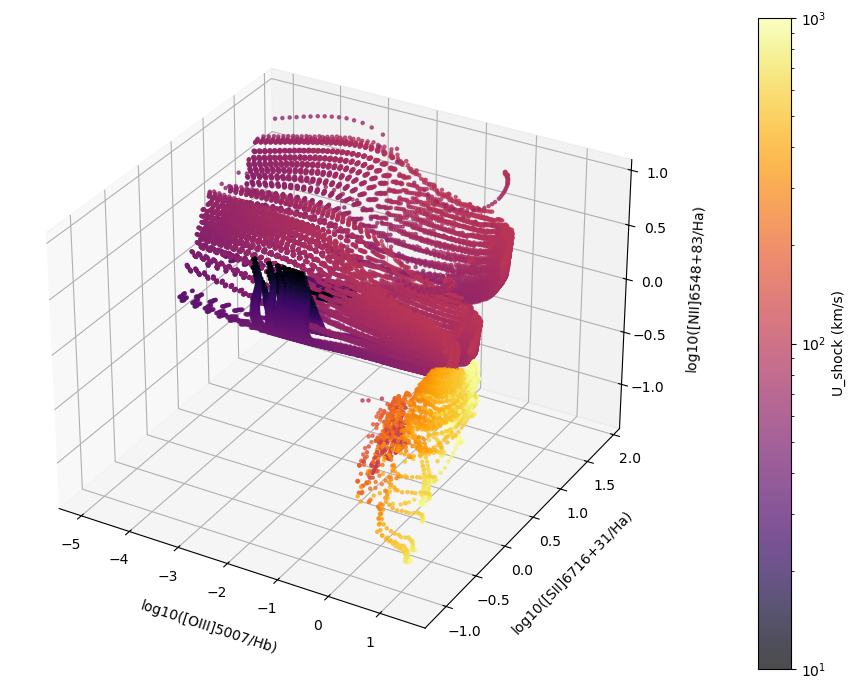

In [18]:
# Load the data
data = np.loadtxt('shock_models_slow_fast_V.txt')

# the file has columns in the following order:
# log([OIII]/Hb), log([SII]/Ha), log([NII]/Ha), shock velocity
x = data[:, 0]  # log([OIII]5007/Hb)
y = data[:, 1]  # log([SII]6716+31/Ha)
z = data[:, 2]  # log([NII]6548+83/Ha)
v = data[:, 3]  # shock velocity

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


# Scatter plot with colormap
img = ax.scatter(x, y, z, c=v, cmap='inferno',norm=matplotlib.colors.LogNorm(), marker='.', alpha=0.7)

# Axis labels
ax.set_xlabel('log10([OIII]5007/Hb)', labelpad=10)
ax.set_ylabel('log10([SII]6716+31/Ha)', labelpad=10)
ax.set_zlabel('log10([NII]6548+83/Ha)', labelpad=10)

# Colorbar
cbar = fig.colorbar(img, ax=ax, pad=0.1)
cbar.set_label('U_shock (km/s)')



plt.tight_layout()
plt.show()

In [19]:
from scipy.interpolate import LinearNDInterpolator

interpolator = LinearNDInterpolator(list(zip(x, y, z)), v)

mask_log = (rat_OIII_Hb_snr_f > 0) & (rat_SII_Ha_snr_f > 0) & (rat_NII_Ha_snr_f > 0)

log_OIII_Hb = np.log10(rat_OIII_Hb_snr_f[mask_log])
log_SII_Ha = np.log10(rat_SII_Ha_snr_f[mask_log])
log_NII_Ha = np.log10(rat_NII_Ha_snr_f[mask_log])

points_to_interp = np.stack([log_OIII_Hb, log_SII_Ha, log_NII_Ha], axis=1)

vel_estimates = interpolator(points_to_interp)

print("Estimated Shock Velocities:", vel_estimates)

Estimated Shock Velocities: [112.02360141  94.36204376 125.07739437  98.62815798 126.5234904
 102.64714252 107.82018336 139.57579998 146.1991794  179.80037735
 167.56102229 101.19055495  98.47722335 101.8696805           nan
  97.07874135 137.91575993 138.46140035 125.52443567 167.87728744
 115.58312549          nan 190.84118134 126.01071022 154.77837381
 136.65946493          nan 135.11489254          nan          nan
 157.10148243 141.17629661 130.94539946          nan 160.11684183
          nan 114.09742414 158.11920496 104.71202785  97.59853952
          nan 145.17734039 109.36721739 144.67564796 156.03863726
 647.60145194          nan 124.22265214 187.09688417          nan
 124.36586303          nan          nan 152.6504449  133.95745319
 118.38141004 196.88018575 133.01837677          nan 103.71287677
 221.02562871 130.93128659 110.57132917          nan 152.06667277
          nan          nan 220.38260306          nan          nan
 198.58521095          nan 132.27283082 169.20641

In [20]:
output_file = "reg/NGC0628_NII.reg"
output_txt = "special_ratios_NGC0628.txt"

mask_vel = ~np.isnan(vel_estimates) # velocities outside the model
indx = np.where(~mask_vel)[0]

# Obrim ambdós fitxers en mode escriptura
with open(output_file, "w") as f, open(output_txt, "w") as f_t:
    # Escriure la capçalera del fitxer de ratios
    f_t.write("x_coord\ty_coord\t[SII]/Hα\t[NII]/Hα\t[OIII]/Hβ\n")
    
    for i in indx:
        print(i, diag_snr_f[i])
        
        # Write coordinates and ratio values
        f_t.write(f"{x_snr_f[i]:.3f}\t{y_snr_f[i]:.3f}\t{rat_SII_Ha_snr_f[i]:.3f}\t{rat_NIIa_Ha_snr_f[i]:.3f}\t{rat_OIII_Hb_snr_f[i]:.3f}\n")
        f.write(f"circle({x_snr_f[i]},{y_snr_f[i]},{aper_snr_f[i]})\n")


14 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
21 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
26 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
28 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
29 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
33 ['SII-NII' 'NII-OIII' '' 'NII-SII-OIII' '']
35 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
40 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
46 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
49 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
51 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
52 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
58 ['SII-NII' 'NII-OIII' '' 'NII-SII-OIII' '']
63 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
65 ['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
66 ['SII-NII' 'NII-OIII' '' 'NII-SII-OIII' '']
68 ['SII-NII' 'NII-OIII' 'SII-OIII' '' 'SII-Ha']
69 ['SII-NII' 'NI

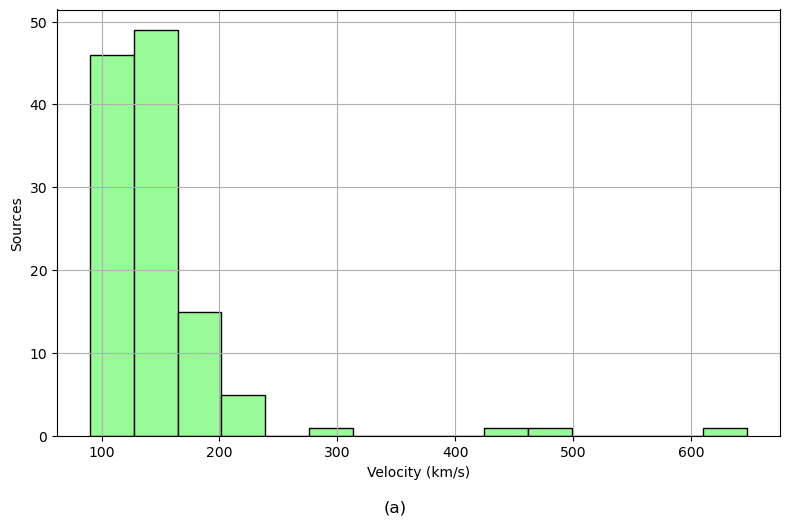

90.07155083325061 647.6014519425756


In [21]:
# Remove NaN values if there are any
vel_clean = vel_estimates[mask_vel]


# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(vel_clean, bins=15, color='palegreen', edgecolor='black')
plt.xlabel("Velocity (km/s)")
plt.ylabel("Sources")
plt.grid(True)
plt.figtext(0.5, -0.035, "(a)", ha='center', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.savefig('shock_vel_NGC0628.png')
plt.show()



print(min(vel_clean), max(vel_clean))

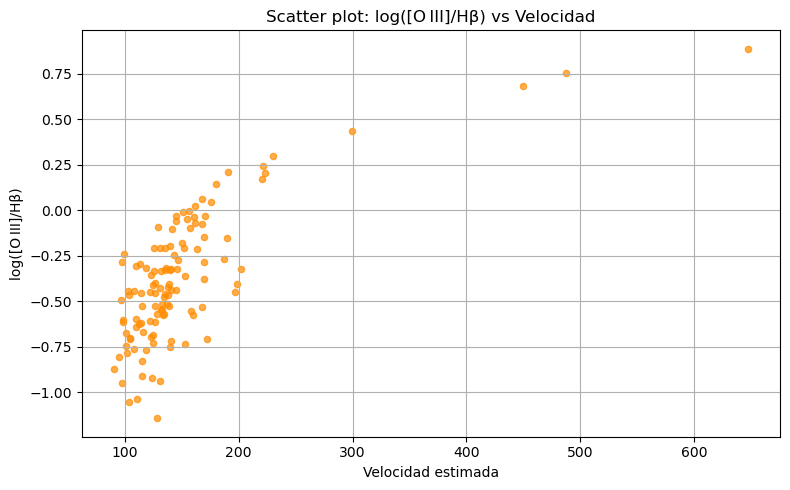

In [22]:
# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(vel_clean,log_OIII_Hb[mask_vel], s=20, alpha=0.7, c='darkorange')
plt.xlabel("Velocidad estimada")
plt.ylabel("log([O III]/Hβ)")
plt.title("Scatter plot: log([O III]/Hβ) vs Velocidad")
plt.grid(True)
plt.tight_layout()
plt.show()

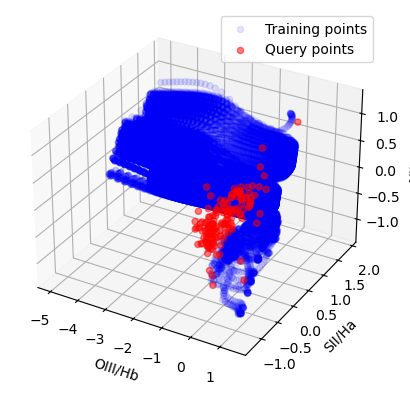

In [23]:
# Set of points that define the interpolation volume
points_interp = np.stack([x, y, z], axis=1)

# Points where you want to estimate the velocity
points_query = np.stack([log_OIII_Hb, log_SII_Ha, log_NII_Ha], axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Training points
ax.scatter(points_interp[:,0], points_interp[:,1], points_interp[:,2], color='blue', label='Training points', alpha=0.1)

# Query points
ax.scatter(points_query[:,0], points_query[:,1], points_query[:,2], color='red', label='Query points', alpha=0.5)

ax.set_xlabel("OIII/Hb")
ax.set_ylabel("SII/Ha")
ax.set_zlabel("NII/Ha")
ax.legend()
plt.show()

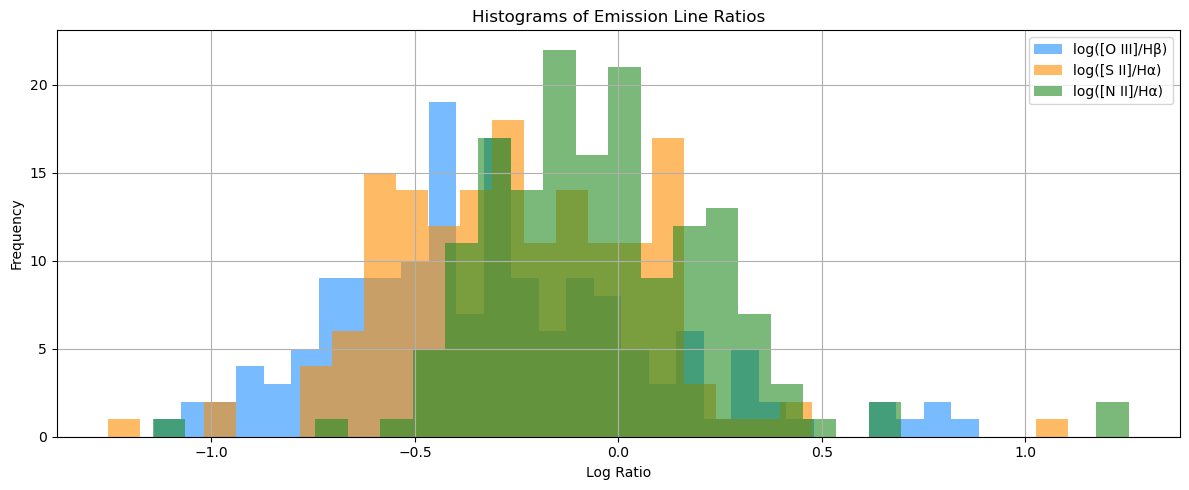

In [24]:
mask_log = (rat_OIII_Hb_snr_f > 0) & (rat_SII_Ha_snr_f > 0) & (rat_NII_Ha_snr_f > 0)

log_OIII_Hb = np.log10(rat_OIII_Hb_snr_f[mask_log])
log_SII_Ha = np.log10(rat_SII_Ha_snr_f[mask_log])
log_NII_Ha = np.log10(rat_NII_Ha_snr_f[mask_log])

# Plot histograms
plt.figure(figsize=(12, 5))

plt.hist(log_OIII_Hb, bins=30, alpha=0.6, label='log([O III]/Hβ)', color='dodgerblue')
plt.hist(log_SII_Ha, bins=30, alpha=0.6, label='log([S II]/Hα)', color='darkorange')
plt.hist(log_NII_Ha, bins=30, alpha=0.6, label='log([N II]/Hα)', color='forestgreen')

plt.xlabel('Log Ratio')
plt.ylabel('Frequency')
plt.title('Histograms of Emission Line Ratios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
densities_dict_2={}
for T in temperatures:
    densities = S2.getTemDen(rat_SIIa_SIIb_snr_f, tem=T, wave1=6716, wave2=6731)
    densities_dict_2[T] = densities

In [26]:
headers = [
    'x', 'y', 'aper', 'diag',
    'Ha', 'Hb', 'OIII', 'SII', 'NIIa', 'SIIa', 'SIIb', 'NII'
]

# we add the 4 densities
density_keys = list(densities_dict_2.keys()) 
density_headers = [f'dens_{T}' for T in density_keys]

headers += density_headers + ['vel']

# Obrim fitxer per escriure
with open("resultats_final_NGC0628.csv", "w") as f:
    # Escrivim la capçalera
    f.write('\t'.join(headers) + '\n')

    # Iterem per files
    for i in range(len(x_snr_f)):
        row = [
            x_snr_f[i],
            y_snr_f[i],
            aper_snr_f[i],
            diag_snr_f[i],
            Ha_snr_f[i],
            Hb_snr_f[i],
            OIII_snr_f[i],
            SII_snr_f[i],
            NIIa_snr_f[i],
            SIIa_snr_f[i],
            SIIb_snr_f[i],
            NII_snr_f[i],
        ]

        # Afegim densitats
        for T in density_keys:
            row.append(densities_dict_2[T][i])

        # Afegim velocitat
        row.append(vel_estimates[i])

        # Convertim a string i escrivim
        row_str = '\t'.join([str(val) for val in row])
        f.write(row_str + '\n')